In [ ]:
# default_exp train

## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.datasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

import numpy as np
from tqdm import tqdm
from copy import deepcopy

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "train_master"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 50
numSamplesToKeep = np.infty #if not debugging
latentDim = 512
filters = 128
num_conv = 2 # breaks when less than 2
simLen = 200
stack = False
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = False
repeat = 0
skip_connection = False
if DEBUG:
    epochs = 2
    numSamplesToKeep = 2000
    
versionName = versionName + '_latentDim{}_filters{}_bz{}_numConv{}_stream{}_jacobian{}_epochs{}_stack{}'.format(latentDim,filters,bz,num_conv,createStreamFcn,doJacobian,epochs,stack)
versionName

'train_master_GPUs0123_latentDim512_filters128_bz50_numConv2_streamFalse_jacobianFalse_epochs1_stackFalse'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Tue Aug 11 17:32:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     9W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
4
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Tue Aug 11 17:32:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   24C    P2    59W / 250W |    510MiB / 12196MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     11MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
print((len(trainData),len(testData)))

(19000, 2000)


In [ ]:
# datasets may be smaller because: numSamplesToKeep 
testDataset = MantaFlowDataset(testData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
len(trainDataset), len(testDataset)

100%|██████████| 19000/19000 [09:35<00:00, 33.04it/s]


(19000, 2000)

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [ ]:
X,p = next(iter(trainDataLoader))
X = X.to(device)
p = p.to(device)
X.shape, p.shape

(torch.Size([50, 2, 128, 96]), torch.Size([50, 3]))

In [ ]:
model = AE_xhat_zV2(X, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device=device)

if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

82 layers require gradients (unfrozen) out of 82 layers
12,748,290 parameters require gradients (unfrozen) out of 12,748,290 parameters


In [ ]:
Xhat,z = model(X)
Xhat.shape, z.shape

(torch.Size([50, 2, 128, 96]), torch.Size([50, 512]))

## Loss Function

In [ ]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [ ]:
pred = stream2uv(Xhat,device)
pred.shape

torch.Size([50, 2, 128, 96])

In [ ]:
loss(pred,X,device)

tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
p_loss(z,p)

tensor(0.5083, device='cuda:0', grad_fn=<MseLossBackward>)

## Set LR

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    from copy import deepcopy
    model.return_z = False
    ae_dataset = deepcopy(trainDataset)
    ae_dataset.AE = True # only output (X,X), i.e. no p.
    dataLoader = DataLoader(ae_dataset,batch_size=bz)
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,dataLoader)
    model.return_z = True

In [ ]:
max_lr = .0001
start_lr = 5*max_lr/10
opt = create_opt(max_lr,model)
#opt = torch.optim.Adam(model.parameters(),lr=start_lr,betas=(.5,.999))
lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

## Train

In [ ]:
# EXPORT
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        X,p = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        p = p.to(device)

        # zero the parameter gradients
        opt.zero_grad()

        X_hat, z = model(X)
        pl = p_loss(z,p)
        ll = loss(X_hat,X,device)
        combined_loss = pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        
        batch_ploss = pl.item()
        running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            running_ploss = 0.0

    return batch_loss, tensorboard_recorder_step, total_steps


In [ ]:
# EXPORT
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        X,p = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        p = p.to(device)
        
        perc = len(X)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            X_hat, z = model(X)

        # loss
        combined_loss = p_loss(z,p) + loss(X_hat,X,device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(X_hat, X)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, p_loss, loss,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, p_loss, loss, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)
    
    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    if trainLoss > 100:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1 ---
trainLoss: 4.7342e-02
valLoss: 5.1191e-02
Better valLoss: 5.1191e-02, Saving models...


100%|██████████| 1/1 [00:46<00:00, 46.12s/it]

---------- Finished Training ----------


## Compare: Generated vs. Simulated

In [ ]:
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()
sampleBatch = next(iter(testDataLoader))
X,p = sampleBatch
X = X.to(device)

with torch.no_grad():
    X_hat, p = model(X)

if createStreamFcn:
    X_hat = stream2uv(X_hat,device)
    
X.shape, p.shape, X_hat.shape

(torch.Size([50, 2, 128, 96]),
 torch.Size([50, 512]),
 torch.Size([50, 2, 128, 96]))

### Visualize full simulation

In [ ]:
simData = getSingleSim(sim=simVizIndex,dataDirec=testData)
simDataset = MantaFlowDataset(simData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
simDataLoader = DataLoader(simDataset,batch_size=1)

100%|██████████| 200/200 [00:03<00:00, 53.97it/s]


In [ ]:
XX = []
Real_X = []
model.eval()
for i, sampleBatch in enumerate(simDataLoader,start=1):
    with torch.no_grad():
        X,p = sampleBatch
        X = X.to(device)
        p = p.to(device)
        Real_X.append(X)
        
        X_hat,_ = model(X)
        
        if createStreamFcn:
            X_hat = stream2uv(X_hat,device)
            
        XX.append(X_hat)
        
        #X = X.detach().cpu().squeeze()
        #X_hat = X_hat.detach().cpu().squeeze()
        #plotSampleWprediction(X, X_hat)

Real_X = torch.cat(Real_X,axis=0).to('cpu')
Real_X_img = convertSimToImage(Real_X)

Surr_X = torch.cat(XX,axis=0).to('cpu')
Surr_X_img = convertSimToImage(Surr_X)

### Metrics

In [ ]:
rmse(Real_X,Surr_X)

tensor(0.0538)

In [ ]:
rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
rel_error

tensor(0.4036)

### Make Movie

In [ ]:
Xrgb = torch.cat([Real_X_img, Surr_X_img], dim=3)
Xrgb.shape

torch.Size([200, 3, 128, 192])

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


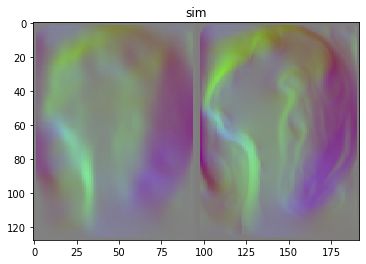

In [ ]:
outGif = '{}.gif'.format(versionName)
create_movie(Xrgb.detach().numpy(),outfile=outGif)

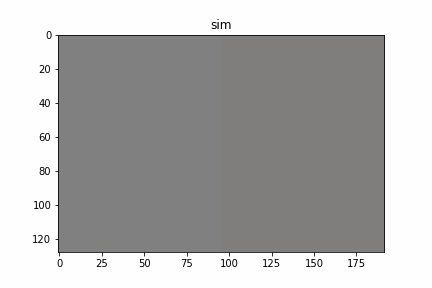

In [ ]:
from IPython.display import Image
Image(filename=outGif)